In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(32)

dates = pd.date_range(start='1990-01-01', periods=12784, freq='d')
products = ['Gear', 'Shaft', 'Bearing']

# Base demand and different seasonal patterns for each product
product_settings = {
    'Gear': {'base': 150, 'trend': 0.01, 'amplitude': 50, 'phase': 0},
    'Shaft': {'base': 200, 'trend': 0.005, 'amplitude': 30, 'phase': np.pi / 2}, # Different season
    'Bearing': {'base': 100, 'trend': 0.02, 'amplitude': 0, 'phase': 0} # Just trend, no season
}

data = []
for i, date in enumerate(dates):
    row = [date]
    day_of_year = date.dayofyear

    for product in products:
        settings = product_settings[product]

        # 1. Add a linear trend (slowly increases over 12775 days)
        trend = settings['trend'] * i

        # 2. Add seasonality (a yearly cycle using a sine wave)
        amplitude = settings['amplitude']
        phase = settings['phase']
        seasonality = amplitude * np.sin((day_of_year / 365.25) * 2 * np.pi + phase)

        # 3. Add random noise (much smaller than the signal)
        noise = np.random.randint(-15, 16) # Smaller noise range

        # Combine all parts
        units = int(settings['base'] + trend + seasonality + noise)

        # Ensure demand is not negative
        if units < 10:
            units = 10

        row.append(units)
    data.append(row)

df = pd.DataFrame(data, columns=['Date'] + products)
df.to_csv('factory_demand.csv', index=False)

print("Data generated successfully!")
print(df.head())

Data generated successfully!
        Date  Gear  Shaft  Bearing
0 1990-01-01   158    225       90
1 1990-01-02   158    242      115
2 1990-01-03   161    233      113
3 1990-01-04   145    244      110
4 1990-01-05   142    219       95


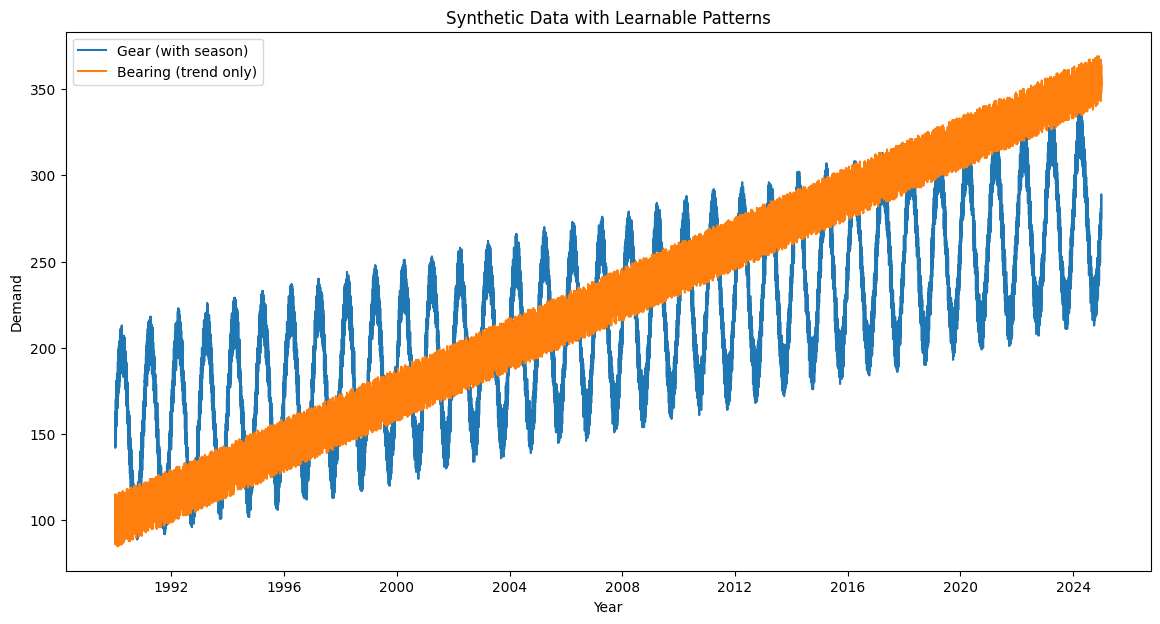

In [ ]:
# --- Plot the data to see the patterns ---
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Gear'], label='Gear (with season)')
plt.plot(df['Date'], df['Bearing'], label='Bearing (trend only)')
plt.title('Synthetic Data with Learnable Patterns')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.show()

Decomposing 'Gear' data (this may take a moment)...
Decomposition complete.


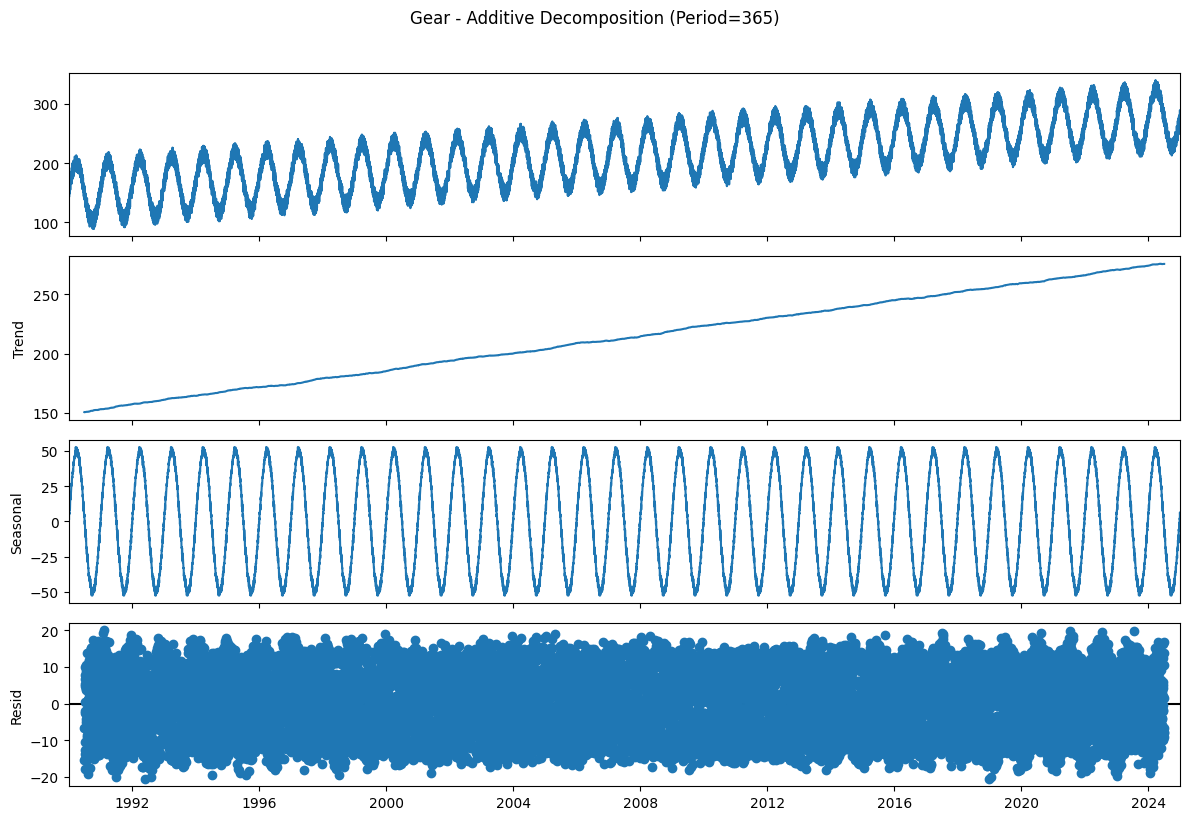


DataFrame with decomposed components (showing NaNs from calculation):
            Gear  Shaft  Bearing  base_trend  seasonal  noise_residual
Date                                                                  
1990-01-01   158    225       90         NaN -3.839403             NaN
1990-01-02   158    242      115         NaN -0.879290             NaN
1990-01-03   161    233      113         NaN -2.183964             NaN
1990-01-04   145    244      110         NaN -0.929653             NaN
1990-01-05   142    219       95         NaN -0.204109             NaN
1990-01-06   149    218       96         NaN  2.314666             NaN
1990-01-07   158    217       86         NaN  1.215875             NaN
1990-01-08   143    217      109         NaN  6.352620             NaN
1990-01-09   152    232       95         NaN  5.078969             NaN
1990-01-10   163    232       89         NaN  5.920710             NaN

Showing middle of DataFrame where values are calculated:
            Gear  S

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# ---------- 1. Load Data ----------
csv_path = "factory_demand.csv"
df = pd.read_csv(csv_path, parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Select one product to analyze
product_name = 'Gear'
product_data = df[[product_name]].dropna()

# ---------- 2. Define Parameters ----------
# Our synthetic data was daily with a yearly pattern
seasonal_period = 365
# Our synthetic data was built by adding components, so we use 'additive'
model_type = 'additive'

# ---------- 3. Decompose the Time Series ----------
print(f"Decomposing '{product_name}' data (this may take a moment)...")

# This is the main function
decomposition = seasonal_decompose(
    product_data,
    model=model_type,
    period=seasonal_period
)

print("Decomposition complete.")

# ---------- 4. Plot the Results ----------
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle(f'{product_name} - {model_type.title()} Decomposition (Period={seasonal_period})', y=1.02)
plt.tight_layout()
plt.show()

# ---------- 5. Access the Components ----------
# You can also add the components back to your DataFrame
df['base_trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal
df['noise_residual'] = decomposition.resid

# The first and last 'period/2' values of the trend/residual will be NaN
# This is because a centered moving average is used to find the trend
print("\nDataFrame with decomposed components (showing NaNs from calculation):")
print(df.head(10))

print("\nShowing middle of DataFrame where values are calculated:")
print(df.iloc[180:190])

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ---------- 1. Load Data ----------
csv_path = "factory_demand.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
else:
    raise FileNotFoundError(f"CSV file '{csv_path}' not found! Please run the pattern generation script.")

products = ['Gear', 'Shaft', 'Bearing']
n_features = len(products)
data = df[products].values

# ---------- 2. Parameters ----------
# We'll use 60 days (2 months) to predict the next day
n_steps = 60

# ---------- 3. Normalize ----------
# Scale all 3 features together
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------- 4. Create Sequences ----------
# This function works for multivariate data automatically
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])  # Input sequence (shape: (n_steps, n_features))
        y.append(data[i+n_steps])    # Output (shape: (n_features,))
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, n_steps)
# X.shape will be (samples, 60, 3)
# y.shape will be (samples, 3)

# ---------- 5. Train/Test Split ----------
train_size = int(0.9 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# ---------- 6. Build LSTM Model ----------
model = Sequential()
model.add(LSTM(512, activation="tanh", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True,activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(16,activation="tanh"))
model.add(Dense(n_features)) # <-- KEY CHANGE: Output 3 values
model.compile(optimizer="adam", loss="mse")

model.summary()

es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

print("\nStarting model training...")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=24,
    callbacks=[es],
    verbose=1
)
print("Training complete.")

# ---------- 7. Model Evaluation ----------
y_pred_val = model.predict(X_val)

# We must inverse_transform the predictions and actuals
y_val_orig = scaler.inverse_transform(y_val)
y_pred_val_orig = scaler.inverse_transform(y_pred_val)

print("\n--- Model Evaluation (on validation set) ---")
for i, product in enumerate(products):
    mae = mean_absolute_error(y_val_orig[:, i], y_pred_val_orig[:, i])
    rmse = np.sqrt(mean_squared_error(y_val_orig[:, i], y_pred_val_orig[:, i]))
    mape=mean_absolute_percentage_error(y_val_orig[:, i], y_pred_val_orig[:, i])
    print(f"\nProduct: {product}")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  MAPE = {mape:.2f}")

# ---------- 8. Forecast ----------
user_input = input("\nEnter a future date to forecast (YYYY-MM-DD): ")
target_date = pd.to_datetime(user_input)
last_date = df.index[-1]

if target_date <= last_date:
    print(f"Date must be after last historical date ({last_date.date()})")
else:
    days_ahead = (target_date - last_date).days
    print(f"Forecasting {days_ahead} days ahead ...")

    # Get the last sequence from the *scaled* data
    last_seq_scaled = scaled[-n_steps:].copy()

    for _ in range(days_ahead):
        # Reshape to (1, n_steps, n_features)
        input_seq = last_seq_scaled.reshape(1, n_steps, n_features)

        # Predict the next step (shape will be (1, n_features))
        pred_scaled = model.predict(input_seq)

        # Append the new prediction to the sequence
        # and remove the first item to keep the window size
        last_seq_scaled = np.vstack([last_seq_scaled, pred_scaled])[-n_steps:]

    # The final prediction is the last item in our sequence
    final_pred_scaled = last_seq_scaled[-1].reshape(1, n_features)

    # Inverse transform to get the real values
    final_pred_orig = scaler.inverse_transform(final_pred_scaled)

    print(f"\nForecasted demand on {target_date.date()}:")
    for i, product in enumerate(products):
        print(f"  {product}: {final_pred_orig[0, i]:.0f} units")

X_train shape: (11451, 60, 3)
y_train shape: (11451, 3)
X_val shape: (1273, 60, 3)
y_val shape: (1273, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 512)        │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,355 (8.04 MB)

 Trainable params: 2,106,355 (8.04 MB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - loss: 0.0197 - val_loss: 0.0026
Epoch 2/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 3/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 4/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 9/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 10/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 11/200
478/478 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0025 - val_loss

In [ ]:
model.save("forcasting_lstm_model.keras")

In [ ]:
import joblib

# ... your training code ...

# ---------- 3. Normalize ----------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# --- ADD THIS ---
# Save the scaler object to a .pkl file
joblib.dump(scaler, "my_scaler.pkl")
print("Scaler saved as 'my_scaler.pkl'")
# ---------------

# ... rest of your training code ...

Scaler saved as 'my_scaler.pkl'


In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler # <-- Need this import for joblib

# ---------- 1. Set Parameters (Must match training) ----------
n_steps = 60
n_features = 3
products = ['Gear', 'Shaft', 'Bearing']

# ---------- 2. Load the Model and Scaler ----------
print("Loading model from 'forcasting_lstm_model.keras'...")
model = load_model("forcasting_lstm_model.keras")
print("Model loaded.")

print("Loading scaler from 'my_scaler.pkl'...")
scaler = joblib.load("my_scaler.pkl")
print("Scaler loaded.")

# ---------- 3. Get the Last Known Data ----------
# We need the last 'n_steps' from the original dataset
# to build the input sequence for the next prediction.
csv_path = "factory_demand.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: Data file not found at {csv_path}")
    exit()

# Get the last n_steps rows of the products
last_known_data = df[products].values[-n_steps:]

# --- FIX: You must scale the data *before* using it ---
last_known_data_scaled = scaler.transform(last_known_data)
# ----------------------------------------------------

# ---------- 4. Ask user for future date ----------
user_input = input("Enter a future date to forecast (YYYY-MM-DD): ")
target_date = pd.to_datetime(user_input)
last_date = pd.to_datetime(df['Date'].iloc[-1])

if target_date <= last_date:
    print(f"Date must be after last historical date ({last_date.date()})")
else:
    days_ahead = (target_date - last_date).days
    print(f"Forecasting {days_ahead} day(s) ahead ...")

    # Start with the last n_steps of *scaled* data
    last_seq = last_known_data_scaled.copy()
    forecast_values = []

    # Predict sequentially day by day
    for _ in range(days_ahead):
        input_seq = last_seq[-n_steps:].reshape(1, n_steps, n_features)
        pred_scaled = model.predict(input_seq)

        # We only need the final unscaled values
        pred_final = scaler.inverse_transform(pred_scaled)
        forecast_values.append(pred_final[0])

        # Add predicted *scaled* value to sequence for next step
        last_seq = np.vstack([last_seq, pred_scaled])

    # ---------- 5. Optimization with PuLP ----------

    # Get the final forecast for the target date
    final_forecast = forecast_values[-1]
    forecasted_demand = np.round(final_forecast).astype(int)
    demand_dict = dict(zip(products, forecasted_demand))

    print(f"\nForecasted Demand for {target_date.date()}:", demand_dict)

    try:
        from pulp import LpMaximize, LpProblem, LpVariable, value

        # Decision variables: cannot produce negative units
        # The forecast is now an upper bound on production
        x = {p: LpVariable(f"{p}_units", lowBound=100, upBound=demand_dict[p]) for p in products}

        # Objective: maximize profit
        profit_per_unit = {'Gear': 50, 'Shaft': 50, 'Bearing': 50}
        model_lp = LpProblem("Factory_Production", LpMaximize)
        model_lp += sum(profit_per_unit[p] * x[p] for p in products), "Total_Profit"

        # Constraints (example)
        machine_hours = {'Gear': 100, 'Shaft': 110, 'Bearing': 95}
        labor_hours   = {'Gear': 200, 'Shaft': 300, 'Bearing': 350}
        max_machine_hours = 72000 # Increased constraints to be realistic
        max_labor_hours = 80000 # Increased constraints

        model_lp += sum(machine_hours[p]*x[p] for p in products) <= max_machine_hours, "Machine_Hours"
        model_lp += sum(labor_hours[p]*x[p] for p in products) <= max_labor_hours, "Labor_Hours"

        # Solve
        model_lp.solve()

        # Print results
        print("\n--- Optimized Production Plan ---")
        for p in products:
            print(f"  Produce {x[p].value():.0f} units of {p}")
        print(f"Maximum Profit = {value(model_lp.objective):.2f}")

    except ImportError:
        print("\nPuLP library not found. Skipping optimization.")
        print("Install with: pip install pulp")


Loading model from 'forcasting_lstm_model.keras'...
Model loaded.
Loading scaler from 'my_scaler.pkl'...
Scaler loaded.
Enter a future date to forecast (YYYY-MM-DD): 2025-1-2
Forecasting 2 day(s) ahead ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Forecasted Demand for 2025-01-02: {'Gear': np.int64(271), 'Shaft': np.int64(289), 'Bearing': np.int64(339)}

--- Optimized Production Plan ---
  Produce 75 units of Gear
  Produce 100 units of Shaft
  Produce 100 units of Bearing
Maximum Profit = 13750.00


In [4]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler # <-- Need this import for joblib

# ---------- 1. Set Parameters (Must match training) ----------
n_steps = 60
n_features = 3
products = ['Gear', 'Shaft', 'Bearing']

# ---------- 2. Load the Model and Scaler ----------
print("Loading model from 'forcasting_lstm_model.keras'...")
model = load_model("forcasting_lstm_model.keras")
print("Model loaded.")

print("Loading scaler from 'my_scaler.pkl'...")
scaler = joblib.load("my_scaler.pkl")
print("Scaler loaded.")

# ---------- 3. Get the Last Known Data ----------
csv_path = "factory_demand.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: Data file not found at {csv_path}")
    print("Please run the 'factory_demand_with_patterns.csv' generation script first.")
    exit()

last_known_data = df[products].values[-n_steps:]
last_known_data_scaled = scaler.transform(last_known_data)

# ---------- 4. Ask user for future date ----------
user_input = input("Enter a future date to forecast (YYYY-MM-DD): ")
target_date = pd.to_datetime(user_input)
last_date = pd.to_datetime(df['Date'].iloc[-1])

if target_date <= last_date:
    print(f"Date must be after last historical date ({last_date.date()})")
else:
    days_ahead = (target_date - last_date).days
    print(f"Forecasting {days_ahead} day(s) ahead ...")

    last_seq = last_known_data_scaled.copy()
    forecast_values = []

    for _ in range(days_ahead):
        input_seq = last_seq[-n_steps:].reshape(1, n_steps, n_features)
        pred_scaled = model.predict(input_seq, verbose=0)
        pred_final = scaler.inverse_transform(pred_scaled)
        forecast_values.append(pred_final[0])
        last_seq = np.vstack([last_seq, pred_scaled])

    # ---------- 5. Optimization with PuLP ----------

    final_forecast = forecast_values[-1]
    forecasted_demand = np.maximum(0, np.round(final_forecast)).astype(int)
    demand_dict = dict(zip(products, forecasted_demand))

    print(f"\nForecasted Demand for {target_date.date()}:", demand_dict)

    try:
        from pulp import LpMaximize, LpProblem, LpVariable, value

        # Decision variables:
        x = {p: LpVariable(f"{p}_units", lowBound=5, upBound=demand_dict[p]) for p in products}

        # --- Define Profit & Resource Costs ---
        profit_per_unit = {'Gear': 50, 'Shaft': 40, 'Bearing': 60}
        machine_hours = {'Gear': 0.5, 'Shaft': 0.8, 'Bearing': 0.6}
        labor_hours   = {'Gear': 1.0, 'Shaft': 1.2, 'Bearing': 1.5}

        # --- NEW: Raw Material Needs (per unit) ---
        material_needs = {
            'Gear':    {'Steel': 10, 'Oil': 1, 'Casing': 0},
            'Shaft':   {'Steel': 15, 'Oil': 0.5, 'Casing': 0},
            'Bearing': {'Steel': 5,  'Oil': 2, 'Casing': 1}
        }

        # --- NEW: Storage Space (per unit) ---
        space_per_unit = {'Gear': 0.5, 'Shaft': 1.2, 'Bearing': 0.3} # in m³


        # --- Define Max Available Resources ---
        max_machine_hours = 200
        max_labor_hours = 400
        available_materials = {
            'Steel': 2500,
            'Oil': 150,
            'Casing': 50
        }
        max_warehouse_space = 250 # in m³

        # --- Create PuLP Problem ---
        model_lp = LpProblem("Factory_Production_Plan", LpMaximize)
        model_lp += sum(profit_per_unit[p] * x[p] for p in products), "Total_Profit"

        # --- Add Constraints ---
        model_lp += sum(machine_hours[p]*x[p] for p in products) <= max_machine_hours, "Max_Machine_Hours"
        model_lp += sum(labor_hours[p]*x[p] for p in products) <= max_labor_hours, "Max_Labor_Hours"
        model_lp += sum(space_per_unit[p] * x[p] for p in products) <= max_warehouse_space, "Max_Warehouse_Space"

        # --- NEW: Add Material Constraints ---
        for material in available_materials:
            model_lp += sum(material_needs[p][material] * x[p] for p in products) <= available_materials[material], f"Max_{material}"

        # Solve
        model_lp.solve()

        # Print results
        print("\n--- Optimized Production Plan ---")
        for p in products:
            print(f"  Produce {x[p].value():.0f} units of {p} (Demand was {demand_dict[p]})")

        print("\n--- Resource Utilization ---")
        print(f"  Machine Hours: {sum(machine_hours[p]*x[p].value() for p in products):.0f} / {max_machine_hours}")
        print(f"  Labor Hours:   {sum(labor_hours[p]*x[p].value() for p in products):.0f} / {max_labor_hours}")
        print(f"  Warehouse:     {sum(space_per_unit[p]*x[p].value() for p in products):.0f} / {max_warehouse_space} m³")
        print(f"  Steel:         {sum(material_needs[p]['Steel']*x[p].value() for p in products):.0f} / {available_materials['Steel']}")
        print(f"  Oil:           {sum(material_needs[p]['Oil']*x[p].value() for p in products):.0f} / {available_materials['Oil']}")
        print(f"  Casing:        {sum(material_needs[p]['Casing']*x[p].value() for p in products):.0f} / {available_materials['Casing']}")

        print(f"\nMaximum Profit = {value(model_lp.objective):.2f}")

    except ImportError:
        print("\nPuLP library not found. Skipping optimization.")
        print("Install with: pip install pulp")



Loading model from 'forcasting_lstm_model.keras'...
Model loaded.
Loading scaler from 'my_scaler.pkl'...
Scaler loaded.
Enter a future date to forecast (YYYY-MM-DD): 2025-5-2
Forecasting 122 day(s) ahead ...

Forecasted Demand for 2025-05-02: {'Gear': np.int64(271), 'Shaft': np.int64(227), 'Bearing': np.int64(330)}

--- Optimized Production Plan ---
  Produce 86 units of Gear (Demand was 271)
  Produce 108 units of Shaft (Demand was 227)
  Produce 5 units of Bearing (Demand was 330)

--- Resource Utilization ---
  Machine Hours: 132 / 200
  Labor Hours:   223 / 400
  Warehouse:     174 / 250 m³
  Steel:         2500 / 2500
  Oil:           150 / 150
  Casing:        5 / 50

Maximum Profit = 8912.50


In [3]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler # <-- Need this import for joblib

# ---------- 1. Set Parameters (Must match training) ----------
n_steps = 60
n_features = 3
products = ['Gear', 'Shaft', 'Bearing']
# --- (NEW) Define materials list globally ---
materials = ['Steel', 'Oil', 'Casing']

# ---------- NEW HELPER FUNCTION FOR USER INPUT ----------
def get_resource_constraints():
    """
    Prompts the user to enter ALL economic and physical constraints for the day.
    Includes error handling to ensure valid numbers are entered.
    """
    # Dictionaries to store all user inputs
    low_bounds = {}
    selling_price_per_unit = {}
    material_cost = {}
    machine_hours = {}
    labor_hours = {}
    material_needs = {p: {} for p in products} # Nested dict
    space_per_unit = {}

    while True:
        try:
            # --- 1. Economic Inputs (Prices & Costs) ---
            print("\n--- Enter Economic Inputs ---")
            for p in products:
                selling_price_per_unit[p] = float(input(f"  Selling Price per unit for {p} (e.g., 80): "))

            print("\nEnter Costs:")
            labor_cost_per_hour = float(input(f"  Cost per Labor Hour (e.g., 25): "))
            for m in materials:
                 material_cost[m] = float(input(f"  Cost per unit of {m} (e.g., 2): "))

            # --- 2. Per-Unit Resource Needs (NEW) ---
            print("\n--- Enter Per-Unit Resource Needs ---")
            for p in products:
                print(f"\n  For 1 unit of {p}:")
                machine_hours[p] = float(input(f"    Machine Hours needed (e.g., 0.5): "))
                labor_hours[p] = float(input(f"    Labor Hours needed (e.g., 1.0): "))
                space_per_unit[p] = float(input(f"    Warehouse Space (m³) (e.g., 0.5): "))
                for m in materials:
                    material_needs[p][m] = float(input(f"    Units of {m} needed (e.g., 10): "))

            # --- 3. Minimum Production (Low Bounds) ---
            print("\n--- Enter Minimum Production (low bound) ---")
            for p in products:
                low_bounds[p] = float(input(f"  Min {p} units (e.g., 5): "))

            # --- 4. Physical Resource Availability ---
            print("\n--- Enter Daily Resource Availability ---")
            max_machine_hours = float(input(f"Enter Max Machine Hours (e.g., 200): "))
            max_labor_hours = float(input(f"Enter Max Labor Hours (e.g., 400): "))

            print("\nEnter Available Raw Materials:")
            available_materials = {}
            for m in materials:
                available_materials[m] = float(input(f"  {m} (e.g., 2500): "))

            max_warehouse_space = float(input(f"Enter Max Warehouse Space (m³) (e.g., 250): "))

            # Return all values once they are valid
            return (selling_price_per_unit, labor_cost_per_hour, material_cost,
                    machine_hours, labor_hours, material_needs, space_per_unit,
                    low_bounds, max_machine_hours, max_labor_hours,
                    available_materials, max_warehouse_space)

        except ValueError:
            print("\n[Error] Invalid input. Please enter numbers only. Let's try again.\n")
# ----------------------------------------------------

# ---------- 2. Load the Model and Scaler ----------
print("Loading model from 'forcasting_lstm_model.keras'...")
model = load_model("forcasting_lstm_model.keras")
print("Model loaded.")

print("Loading scaler from 'my_scaler.pkl'...")
scaler = joblib.load("my_scaler.pkl")
print("Scaler loaded.")

# ---------- 3. Get the Last Known Data ----------
csv_path = "factory_demand.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: Data file not found at {csv_path}")
    print("Please run the 'factory_demand.csv' generation script first.")
    exit()

last_known_data = df[products].values[-n_steps:]
last_known_data_scaled = scaler.transform(last_known_data)

# ---------- 4. Ask user for future date ----------
user_input = input("Enter a future date to forecast (YYYY-MM-DD): ")
target_date = pd.to_datetime(user_input)
last_date = pd.to_datetime(df['Date'].iloc[-1])

if target_date <= last_date:
    print(f"Date must be after last historical date ({last_date.date()})")
else:
    days_ahead = (target_date - last_date).days
    print(f"Forecasting {days_ahead} day(s) ahead ...")

    last_seq = last_known_data_scaled.copy()
    forecast_values = []

    for _ in range(days_ahead):
        input_seq = last_seq[-n_steps:].reshape(1, n_steps, n_features)
        pred_scaled = model.predict(input_seq, verbose=0)
        pred_final = scaler.inverse_transform(pred_scaled)
        forecast_values.append(pred_final[0])
        last_seq = np.vstack([last_seq, pred_scaled])

    # ---------- 5. Optimization with PuLP ----------

    final_forecast = forecast_values[-1]
    forecasted_demand = np.maximum(0, np.round(final_forecast)).astype(int)
    demand_dict = dict(zip(products, forecasted_demand))

    print(f"\nForecasted Demand for {target_date.date()}:", demand_dict)

    try:
        from pulp import LpMaximize, LpProblem, LpVariable, value

        # --- (CHANGE) Get all constraints INTERACTIVELY ---
        (selling_price_per_unit, labor_cost_per_hour, material_cost,
         machine_hours, labor_hours, material_needs, space_per_unit,
         low_bounds, max_machine_hours, max_labor_hours,
         available_materials, max_warehouse_space) = get_resource_constraints()
        # --------------------------------------------------

        # Decision variables:
        x = {p: LpVariable(f"{p}_units", lowBound=low_bounds[p], upBound=demand_dict[p]) for p in products}

        # --- (CHANGE) All per-unit definitions are now from user input ---
        # (No hard-coded dictionaries left)
        # ---------------------------------------------------------------

        # --- Create PuLP Problem ---
        model_lp = LpProblem("Factory_Production_Plan", LpMaximize)

        # --- Define Objective as (Revenue - Labor Cost - Material Cost) ---

        # 1. Total Revenue
        total_revenue = sum(selling_price_per_unit[p] * x[p] for p in products)

        # 2. Total Labor Cost
        total_labor_cost = sum(labor_hours[p] * x[p] for p in products) * labor_cost_per_hour

        # 3. Total Material Cost
        total_material_cost = sum(
            material_needs[p][material] * x[p] * material_cost[material]
            for p in products for material in materials # Use global materials list
        )

        # Set the objective
        model_lp += (total_revenue - total_labor_cost - total_material_cost), "Total_Net_Profit"

        # --- Add Constraints ---
        model_lp += sum(machine_hours[p]*x[p] for p in products) <= max_machine_hours, "Max_Machine_Hours"
        model_lp += sum(labor_hours[p]*x[p] for p in products) <= max_labor_hours, "Max_Labor_Hours"
        model_lp += sum(space_per_unit[p] * x[p] for p in products) <= max_warehouse_space, "Max_Warehouse_Space"

        # --- Add Material Constraints ---
        for material in available_materials:
            model_lp += sum(material_needs[p][material] * x[p] for p in products) <= available_materials[material], f"Max_{material}"

        # Solve
        model_lp.solve()

        # Print results
        print("\n--- Optimized Production Plan ---")
        for p in products:
            print(f"  Produce {x[p].value():.0f} units of {p} (Demand was {demand_dict[p]})")

        print("\n--- Resource Utilization ---")
        print(f"  Machine Hours: {sum(machine_hours[p]*x[p].value() for p in products):.0f} / {max_machine_hours}")
        print(f"  Labor Hours:   {sum(labor_hours[p]*x[p].value() for p in products):.0f} / {max_labor_hours}")
        print(f"  Warehouse:     {sum(space_per_unit[p]*x[p].value() for p in products):.0f} / {max_warehouse_space} m³")
        for m in materials:
             print(f"  {m}:           {sum(material_needs[p][m]*x[p].value() for p in products):.0f} / {available_materials[m]}")

        print(f"\nMaximum Net Profit = {value(model_lp.objective):.2f}")

    except ImportError:
        print("\nPuLP library not found. Skipping optimization.")
        print("Install with: pip install pulp")



Loading model from 'forcasting_lstm_model.keras'...
Model loaded.
Loading scaler from 'my_scaler.pkl'...
Scaler loaded.
Enter a future date to forecast (YYYY-MM-DD): 2025-1-1
Forecasting 1 day(s) ahead ...

Forecasted Demand for 2025-01-01: {'Gear': np.int64(270), 'Shaft': np.int64(289), 'Bearing': np.int64(339)}

--- Enter Economic Inputs ---
  Selling Price per unit for Gear (e.g., 80): $70
  Selling Price per unit for Shaft (e.g., 80): $50
  Selling Price per unit for Bearing (e.g., 80): $100

Enter Costs:
  Cost per Labor Hour (e.g., 25): $30
  Cost per unit of Steel (e.g., 2): $2
  Cost per unit of Oil (e.g., 2): $5
  Cost per unit of Casing (e.g., 2): $15

--- Enter Per-Unit Resource Needs ---

  For 1 unit of Gear:
    Machine Hours needed (e.g., 0.5): 0.5
    Labor Hours needed (e.g., 1.0): 1.0
    Warehouse Space (m³) (e.g., 0.5): .2
    Units of Steel needed (e.g., 10): 10
    Units of Oil needed (e.g., 10): 1
    Units of Casing needed (e.g., 10): 0

  For 1 unit of Shaft:
 

In [7]:
import pandas as pd
import numpy as np
import joblib
import streamlit as st
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler # <-- Need this import for joblib
from pulp import LpMaximize, LpProblem, LpVariable, value, LpStatus

# ---------- 1. SET UP THE PAGE ----------
st.set_page_config(page_title="Factory Optimization", layout="wide")
st.title("Smart Factory: LSTM Forecast & PuLP Optimization")
st.write("""
This tool uses a trained LSTM model to forecast future demand, then runs a
Linear Programming model (PuLP) to find the most profitable production plan
based on your factory's real-world constraints.
""")

# ---------- 2. PARAMETERS & MODEL LOADING ----------
# Use st.cache_resource to load models only once
@st.cache_resource
def load_models():
    try:
        model = load_model("forcasting_lstm_model.keras")
        scaler = joblib.load("my_scaler.pkl")
        return model, scaler
    except Exception as e:
        st.error(f"Error loading models: {e}")
        st.error("Please make sure 'forcasting_lstm_model.keras' and 'my_scaler.pkl' are in the same folder.")
        return None, None

model, scaler = load_models()
if model is None:
    st.stop()

# Load the base data for seeding predictions
@st.cache_data
def load_seed_data():
    try:
        df = pd.read_csv("factory_demand_with_patterns.csv")
        return df
    except FileNotFoundError:
        st.error("Error: 'factory_demand_with_patterns.csv' not found.")
        st.stop()

df_seed = load_seed_data()

products = ['Gear', 'Shaft', 'Bearing']
materials = ['Steel', 'Oil', 'Casing']
n_steps = 60
n_features = 3

# ---------- 3. USER INPUT (The "Dashboard") ----------
st.sidebar.header("Step 1: Get Forecast")
target_date_input = st.sidebar.date_input("Select Target Forecast Date")
run_forecast_btn = st.sidebar.button("Run Forecast")

st.sidebar.header("Step 2: Define Factory (Daily Inputs)")

with st.sidebar.expander("Economic Inputs (Prices & Costs)"):
    selling_price_per_unit = {p: st.number_input(f"Selling Price for {p}", min_value=0.0, value=70.0, step=1.0) for p in products}
    labor_cost_per_hour = st.number_input("Cost per Labor Hour", min_value=0.0, value=25.0, step=1.0)
    material_cost = {m: st.number_input(f"Cost per unit of {m}", min_value=0.0, value=2.0, step=0.1) for m in materials}

with st.sidebar.expander("Per-Unit Resource Needs (Factory Specs)"):
    machine_hours = {p: st.number_input(f"{p} Machine Hrs/Unit", min_value=0.0, value=0.5, step=0.1) for p in products}
    labor_hours = {p: st.number_input(f"{p} Labor Hrs/Unit", min_value=0.0, value=1.0, step=0.1) for p in products}
    space_per_unit = {p: st.number_input(f"{p} Warehouse (m³)/Unit", min_value=0.0, value=0.5, step=0.1) for p in products}
    material_needs = {p: {} for p in products}
    for p in products:
        st.subheader(f"Material Needs for {p}")
        for m in materials:
            material_needs[p][m] = st.number_input(f"{m} units for {p}", min_value=0.0, value=5.0, step=0.5, key=f"{p}_{m}")

with st.sidebar.expander("Minimum Production & Resource Limits"):
    low_bounds = {p: st.number_input(f"Min Production for {p}", min_value=0, value=5) for p in products}
    max_machine_hours = st.number_input("Total Machine Hours Available", min_value=0, value=200)
    max_labor_hours = st.number_input("Total Labor Hours Available", min_value=0, value=400)
    available_materials = {m: st.number_input(f"Total {m} Available", min_value=0, value=2500) for m in materials}
    max_warehouse_space = st.number_input("Total Warehouse Space (m³)", min_value=0, value=250)

run_optimize_btn = st.sidebar.button("Run Production Optimization", type="primary")

# ---------- 4. FORECASTING LOGIC ----------
if run_forecast_btn:
    st.session_state.forecast_ran = True

    last_date = pd.to_datetime(df_seed['Date'].iloc[-1])
    target_date = pd.to_datetime(target_date_input)

    if target_date <= last_date:
        st.error(f"Date must be after last historical date ({last_date.date()})")
    else:
        with st.spinner("Running LSTM model to forecast..."):
            days_ahead = (target_date - last_date).days

            last_known_data = df_seed[products].values[-n_steps:]
            last_known_data_scaled = scaler.transform(last_known_data)

            last_seq = last_known_data_scaled.copy()
            for _ in range(days_ahead):
                input_seq = last_seq.reshape(1, n_steps, n_features)
                pred_scaled = model.predict(input_seq, verbose=0)
                last_seq = np.vstack([last_seq[1:], pred_scaled]) # More efficient

            final_pred_scaled = last_seq[-1].reshape(1, n_features)
            final_pred_orig = scaler.inverse_transform(final_pred_scaled)

            forecasted_demand = np.maximum(0, np.round(final_pred_orig)).astype(int)[0]
            demand_dict = dict(zip(products, forecasted_demand))

            # Store in session state to use in optimization
            st.session_state.demand_dict = demand_dict
            st.session_state.target_date = target_date

            st.header(f"Forecast for {target_date.date()}")
            st.table(pd.DataFrame.from_dict(demand_dict, orient='index', columns=['Forecasted Demand']))
            st.info("Forecast complete. Now, adjust your factory inputs on the left and run the optimization.")

# ---------- 5. OPTIMIZATION LOGIC ----------
if run_optimize_btn:
    if 'demand_dict' not in st.session_state:
        st.error("Please run a forecast first (Step 1).")
    else:
        with st.spinner("Running PuLP optimizer..."):
            demand_dict = st.session_state.demand_dict
            target_date = st.session_state.target_date

            # Decision variables:
            x = {p: LpVariable(f"{p}_units", lowBound=low_bounds[p], upBound=demand_dict[p]) for p in products}

            model_lp = LpProblem("Factory_Production_Plan", LpMaximize)

            # Objective Function (from user inputs)
            total_revenue = sum(selling_price_per_unit[p] * x[p] for p in products)
            total_labor_cost = sum(labor_hours[p] * x[p] for p in products) * labor_cost_per_hour
            total_material_cost = sum(
                material_needs[p][material] * x[p] * material_cost[material]
                for p in products for material in materials
            )
            model_lp += (total_revenue - total_labor_cost - total_material_cost), "Total_Net_Profit"

            # Constraints (from user inputs)
            model_lp += sum(machine_hours[p]*x[p] for p in products) <= max_machine_hours, "Max_Machine_Hours"
            model_lp += sum(labor_hours[p]*x[p] for p in products) <= max_labor_hours, "Max_Labor_Hours"
            model_lp += sum(space_per_unit[p] * x[p] for p in products) <= max_warehouse_space, "Max_Warehouse_Space"
            for material in materials:
                model_lp += sum(material_needs[p][material] * x[p] for p in products) <= available_materials[material], f"Max_{material}"

            # Solve
            model_lp.solve()

            # --- 6. DISPLAY RESULTS (The Dashboard) ---
            st.header(f"Optimized Production Plan for {target_date.date()}")

            if LpStatus[model_lp.status] == 'Optimal':
                st.success(f"Optimal Solution Found! Maximum Net Profit = ${value(model_lp.objective):,.2f}")

                # --- Result 1: The Plan ---
                st.subheader("Production Plan")
                plan_data = {
                    'Product': products,
                    'Forecasted Demand': [demand_dict[p] for p in products],
                    'Optimized Production': [int(x[p].value()) for p in products],
                    'Min Production': [low_bounds[p] for p in products]
                }
                plan_df = pd.DataFrame(plan_data).set_index('Product')
                st.dataframe(plan_df)

                # --- Result 2: Visuals ---
                st.bar_chart(plan_df[['Forecasted Demand', 'Optimized Production']])

                # --- Result 3: Bottlenecks (Resource Utilization) ---
                st.subheader("Resource Utilization (Your Bottlenecks)")
                util_data = {
                    'Resource': ['Machine Hours', 'Labor Hours', 'Warehouse Space'] + materials,
                    'Used': [
                        sum(machine_hours[p]*x[p].value() for p in products),
                        sum(labor_hours[p]*x[p].value() for p in products),
                        sum(space_per_unit[p]*x[p].value() for p in products),
                    ] + [sum(material_needs[p][m]*x[p].value() for p in products) for m in materials],
                    'Total': [max_machine_hours, max_labor_hours, max_warehouse_space] + [available_materials[m] for m in materials]
                }
                util_df = pd.DataFrame(util_data)
                util_df['Percentage'] = (util_df['Used'] / util_df['Total']).clip(0, 1) * 100
                st.dataframe(util_df.style.format({'Percentage': '{:.1f}%'}))

                # Plot utilization
                util_plot_df = util_df.set_index('Resource')
                st.bar_chart(util_plot_df['Percentage'])

                bottlenecks = util_df[util_df['Percentage'] == 100.0]['Resource'].tolist()
                if bottlenecks:
                    st.warning(f"**Factory Bottlenecks Identified:** You ran out of {', '.join(bottlenecks)}!")
                else:
                    st.info("No bottlenecks reached. You have surplus capacity.")

            elif LpStatus[model_lp.status] == 'Infeasible':
                st.error("Optimization Failed: Infeasible. This means it's impossible to meet your minimum production goals with your available resources. Try reducing the 'Min Production' or increasing resources.")
            else:
                st.error(f"Optimization Failed. Status: {LpStatus[model_lp.status]}")


2025-10-24 15:53:31.595 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 15:53:31.595 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 15:53:31.862 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-24 15:53:31.863 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 15:53:31.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 15:53:31.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-24 15:53:31.867 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn